# Nutrient analysis of global fisheries

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import arviz as az

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

## Import data

In [3]:
# Nutrients data
ndata = pd.read_csv('https://raw.githubusercontent.com/mamacneil/FishNutrients_sandbox/main/data/all_nutrients_active.csv?token=AADMXIS6XUOXXHBRUYHXE33ATZKZY')
# Traits data
tdata = pd.read_csv('https://raw.githubusercontent.com/mamacneil/FishNutrients_sandbox/main/data/all_traits_active.csv?token=AADMXIUBDENVUVU42KN6ZFTATZKDS')


In [4]:
tdata.columns.values

array(['species', 'Genus', 'Family', 'Order', 'Class', 'spec_code',
       'DemersPelag', 'EnvTemp', 'environment', 'Feeding_path',
       'BodyShape', 'DepthRangeDeep', 'Lmax', 'trophic_level', 'K', 'tm'],
      dtype=object)

In [5]:
# Add traits information to nutritional dataframe
indx = match(ndata.spec_code.unique(),list(tdata.spec_code.values))
rindx = match(ndata.spec_code,list(ndata.spec_code.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus', 'DemersPelag','EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'Lmax','BodyShape', 'K', 'tm']

# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]
ndata.head()

,species,spec_code,nutrient,value,sample_size,variance,sample_form,prep_form,environment,Class,...,Genus,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,Lmax,BodyShape,K,tm
0,Merluccius_merluccius,30,Selenium,65.0000,NaN,10.0,muscle,wet,marine,Actinopterygii,...,Merluccius,demersal,temperate,1075.0,4.40,pelagic,140.0,elongate,0.13,4.80
1,Scomber_scombrus,118,Selenium,208.0000,NaN,26.0,muscle,wet,marine,Actinopterygii,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.26,2.60
2,Scomber_scombrus,118,Zinc,0.8090,11.0,NaN,muscle,wet,marine,Actinopterygii,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.26,2.60
3,Scomber_scombrus,118,Selenium,22.4000,11.0,NaN,muscle,wet,marine,Actinopterygii,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.26,2.60
4,Merluccius_gayi_gayi,324,Zinc,0.1787,11.0,NaN,muscle,wet,marine,Actinopterygii,...,Merluccius,demersal,polar_deep,500.0,4.32,pelagic,87.0,fusiform,0.25,3.67


In [6]:
ndata.columns.values

array(['species', 'spec_code', 'nutrient', 'value', 'sample_size',
       'variance', 'sample_form', 'prep_form', 'environment', 'Class',
       'Order', 'Family', 'Genus', 'DemersPelag', 'EnvTemp',
       'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'Lmax',
       'BodyShape', 'K', 'tm'], dtype=object)

### Datasets

In [7]:
# List available nutrients
Nutrients =  ndata.nutrient.unique()
# Number of nutrients
nnut = len(Nutrients)
# Return sample sizes
pd.DataFrame({'Nutrient':Nutrients,'Sample size':[sum(ndata.nutrient.values==n) for n in Nutrients]})


,Nutrient,Sample size
0,Selenium,299
1,Zinc,556
2,Protein,1004
3,Omega_3,291
4,Calcium,562
5,Iron,587
6,Vitamin_A,259


## ======= Change nutrient here & likelihood in the model ========= #

In [8]:
i = 3
nut = Nutrients[i]
nut

'Omega_3'

In [9]:
nut = Nutrients[i]
print('Now modelling '+nut+'...')

Now modelling Omega_3...


In [10]:
tmpdata = ndata[ndata.nutrient==nut]

# Filter out zeros?
tmpdata = tmpdata[tmpdata.value!=0].copy()

# Response
Y = tmpdata.value.values
Ylog = np.log(Y)
nobs = len(Y)

In [11]:
Y

array([0.166167  , 0.242505  , 0.324954  , 0.20799   , 0.19288   ,
       0.202831  , 1.1195495 , 1.6983124 , 1.00107162, 1.50501819,
       1.78753043, 0.2108    , 1.435     , 2.034     , 0.875     ,
       0.23235   , 0.18941   , 0.03825601, 0.32886633, 0.17793086,
       0.05658584, 0.33356359, 0.11146978, 0.8       , 1.02      ,
       0.4118675 , 0.42835595, 0.19263044, 0.41745025, 0.20668037,
       0.26667802, 1.06700333, 0.99578226, 1.24088521, 0.9645977 ,
       2.9989549 , 2.04144497, 0.30396052, 0.33623694, 0.38960203,
       0.29099738, 0.30099395, 0.25293708, 1.00639378, 0.25122378,
       1.0516328 , 0.6258048 , 0.5983929 , 1.0597176 , 0.23856835,
       0.43492448, 0.05713501, 0.06815404, 0.09726936, 0.77994578,
       0.71387492, 0.63497592, 0.1463644 , 0.26825515, 0.24      ,
       0.28      , 0.68090939, 0.54116889, 1.74977188, 0.99699247,
       1.39256743, 0.6026104 , 0.16864063, 0.59512146, 1.85840805,
       0.93667766, 2.29123523, 0.90461251, 0.23027631, 0.38659

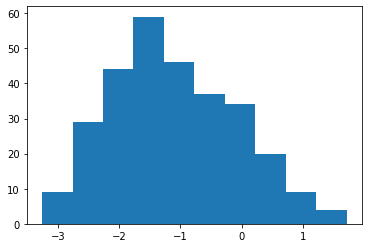

In [12]:
plt.hist(Ylog);

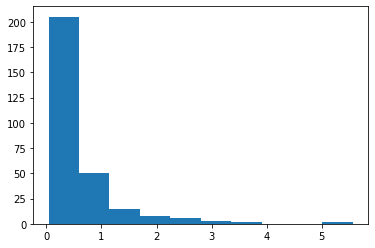

In [13]:
plt.hist(Y);

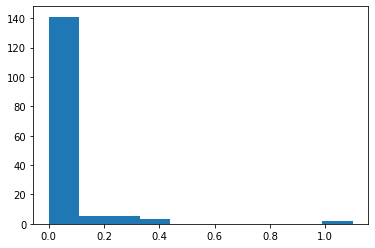

In [14]:
plt.hist(tmpdata.variance);

In [15]:
np.isnan(tmpdata.variance).mean()

0.4639175257731959

In [16]:
np.isnan(tmpdata.value).mean()

0.0

In [17]:
np.isnan(tmpdata.sample_size).mean()

0.3333333333333333

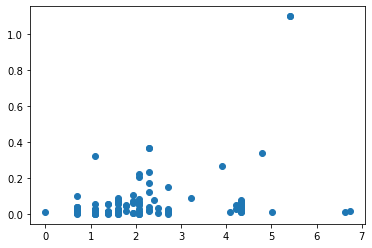

In [18]:
plt.scatter(np.log(tmpdata.sample_size),tmpdata.variance)

In [19]:
# Class index for orders
Class,Icl = subindexall(tmpdata["Class"], tmpdata["Order"])
ncl = len(Class)

Order,Ior = subindexall(tmpdata["Order"], tmpdata["Family"])
nor = len(Order)

Family,Ifa = subindexall(tmpdata["Family"], tmpdata["Genus"])
nga = len(Family)

Genus,Ige = indexall(tmpdata["Genus"])
ngen = len(Genus)

# Covariates
Ih,Habitat = pd.factorize(tmpdata["DemersPelag"], sort=True)
nhabs = len(Habitat)

Ic,Climate = pd.factorize(tmpdata["EnvTemp"], sort=True)
nclim = len(Climate)
MaxDepth = np.log(tmpdata['DepthRangeDeep'].values)
TL = tmpdata['trophic_level'].values
If,FeedingPath = pd.factorize(tmpdata["Feeding_path"], sort=True)

# Environment
Ie,Envt = pd.factorize(tmpdata["environment"], sort=True)
nenvt = len(Envt)
# Freshwater
Fresh = (Ie==list(Envt).index('freshwater'))*1

LMax = np.log(tmpdata['Lmax'].values)

Ib,BodyShape = pd.factorize(tmpdata["BodyShape"], sort=True)

nbod = len(BodyShape)
K = tmpdata['K'].values
tm = np.log(tmpdata['tm'].values)

# Nussiance parameters
Im,Form = pd.factorize(tmpdata["sample_form"], sort=True)
nform = len(Form)
Ip,Prep = pd.factorize(tmpdata["prep_form"], sort=True)
nprep = len(Prep)

# Measurement error and replace zeros
obs_var = tmpdata.variance.replace(0, np.nan)
#obs_var = obs_var[np.isfinite(obs_var)].values

## Specify Bayesian model

In [20]:
coords = {'Class':Class,
    'Order':Order,
    'Family':Family,
    'Genus':Genus,
    'Habitat': Habitat,
    'Climate': Climate,
    'BodyShape': BodyShape,
    'FeedingPath':FeedingPath,
    'Form': Form,
    'Prep': Prep,
    'Envt':Envt}

Nsd = 1

with pm.Model(coords=coords) as Model_1:
    #"""
    # Intercept
    γ0 = pm.Normal('Intercept', 0, Nsd)
    
    if len(coords['Class'])==1:
        σ_o = pm.Exponential('Sigma_order', 1)
        β0_onc = pm.Normal('Ord_nc', 0, 1, dims='Order')
        β0_o = pm.Deterministic('Order_', γ0+β0_onc*σ_o, dims='Order')  
        #β0_o = pm.Normal('Order_', β0_c[Icl], σ_o, dims='Order')
        
    else:    
        # Class
        σ_c = pm.Exponential('Sigma_class', 1)
        β0_cnc = pm.Normal('Cla_nc', 0, 1, dims='Class')
        β0_c = pm.Deterministic('Class_', γ0+β0_cnc*σ_c, dims='Class') 
        #β0_c = pm.Normal('Class_', γ0, σ_c, dims='Class')

        σ_o = pm.Exponential('Sigma_order', 1)
        β0_onc = pm.Normal('Ord_nc', 0, 1, dims='Order')
        β0_o = pm.Deterministic('Order_', β0_c[Icl]+β0_onc*σ_o, dims='Order')  
        #β0_o = pm.Normal('Order_', β0_c[Icl], σ_o, dims='Order')
    
    # Family
    σ_f = pm.Exponential('Sigma_family', 1)
    β0_fnc = pm.Normal('Fam_nc', 0, 1, dims='Family')
    β0_f = pm.Deterministic('Family_', β0_o[Ior]+β0_fnc*σ_f, dims='Family')    
    #β0_f = pm.Normal('Family_', β0_o[Ior], σ_f, dims='Family')
    
    # Genus
    σ_g = pm.Exponential('Sigma_genus', 1)
    β0_gnc = pm.Normal('Gen_nc', 0, 1, dims='Genus')
    β0_g = pm.Deterministic('Genus_', β0_f[Ifa]+β0_gnc*σ_g, dims='Genus')
    #β0_g = pm.Normal('Genus_', β0_f[Ifa], σ_g, dims='Genus')
    #"""

    # Habitat type
    β1 = pm.Normal('Habitat_', 0, Nsd, dims='Habitat')
    # Climate
    β2 = pm.Normal('Climate_', 0, Nsd, dims='Climate')
    # Maximum Depth
    β3 = pm.Normal('MaxDepth', 0, Nsd)
    # Total Length
    β4 = pm.Normal('TL', 0, Nsd)
    # Pelagic/demersal
    β5 = pm.Normal('FeedingPath_', 0, Nsd, dims='FeedingPath')
    # Maximum length
    β6 = pm.Normal('LMax', 0, Nsd)
    # Body form
    β7 = pm.Normal('BodyShape_', 0, Nsd, dims='BodyShape')
    # Growth parameter
    β8 = pm.Normal('K', 0, Nsd)
    # Age at maturity
    β9 = pm.Normal('tm', 0, Nsd)
    
    # Form of sample
    β10 = pm.Normal('Form_', 0, Nsd, dims='Form')
    # Form of prepartion
    β11 = pm.Normal('Prep_', 0, Nsd, dims='Prep')
    
    # Mean model
    μ_ = β0_g[Ige]+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5[If]+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[Im]+β11[Ip]
    
    if nut in ['Protein']:
        μ = μ_
        ν = pm.Uniform('nu', 0, 20)
        σ = pm.Exponential('Sigma', 1)
        Yi = pm.StudentT('Yi', ν, μ, σ, observed=Y)
        ExMu = pm.Deterministic('ExMu', μ_)
    elif nut in ['Zinc','Calcium','Iron','Vitamin_A','Omega_3']:
        μ = μ_
        σ = pm.Exponential('Sigma', 1)
        ν = pm.Uniform('nu', 0, 20)
        Yi = pm.StudentT('Yi', ν, μ, σ, observed=Ylog)
        ExMu = pm.Deterministic('ExMu', tt.exp(μ_))
    elif nut in ['test']:
        μ = pm.math.exp(μ_)
        σ = pm.Uniform('Sigma', 0, 10)
        Yi = pm.Gamma('Yi', alpha=σ, beta=σ/μ, observed=Y)
        ExMu = pm.Deterministic('ExMu', tt.exp(μ_))
    else:
        μ = μ_
        σ = pm.Exponential('Sigma', 1)
        Yi = pm.Normal('Yi', μ, σ, observed=Ylog)
        ExMu = pm.Deterministic('ExMu', tt.exp(μ_))

# Prior predictive distribution

In [21]:
with Model_1:
    prior = pm.sample_prior_predictive(700)
    Model_1_priorp = az.from_pymc3(prior=prior)

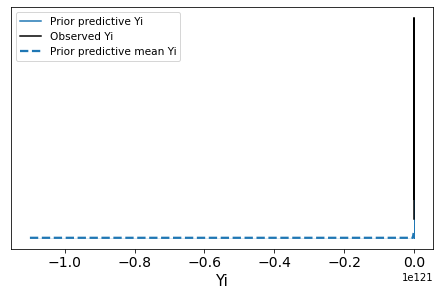

In [22]:
az.plot_ppc(Model_1_priorp, group="prior").figure.savefig(nut+'_PriorPC.jpg')

# Inference

In [23]:
with Model_1:
    trace = pm.sample()

/Users/aaronmacneil/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Sigma, Prep_, Form_, tm, K, BodyShape_, LMax, FeedingPath_, TL, MaxDepth, Climate_, Habitat_, Gen_nc, Sigma_genus, Fam_nc, Sigma_family, Ord_nc, Sigma_order, Cla_nc, Sigma_class, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/aaronmacneil/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/aaronmacneil/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (27), generating only 20 plots
  warnings.warn(


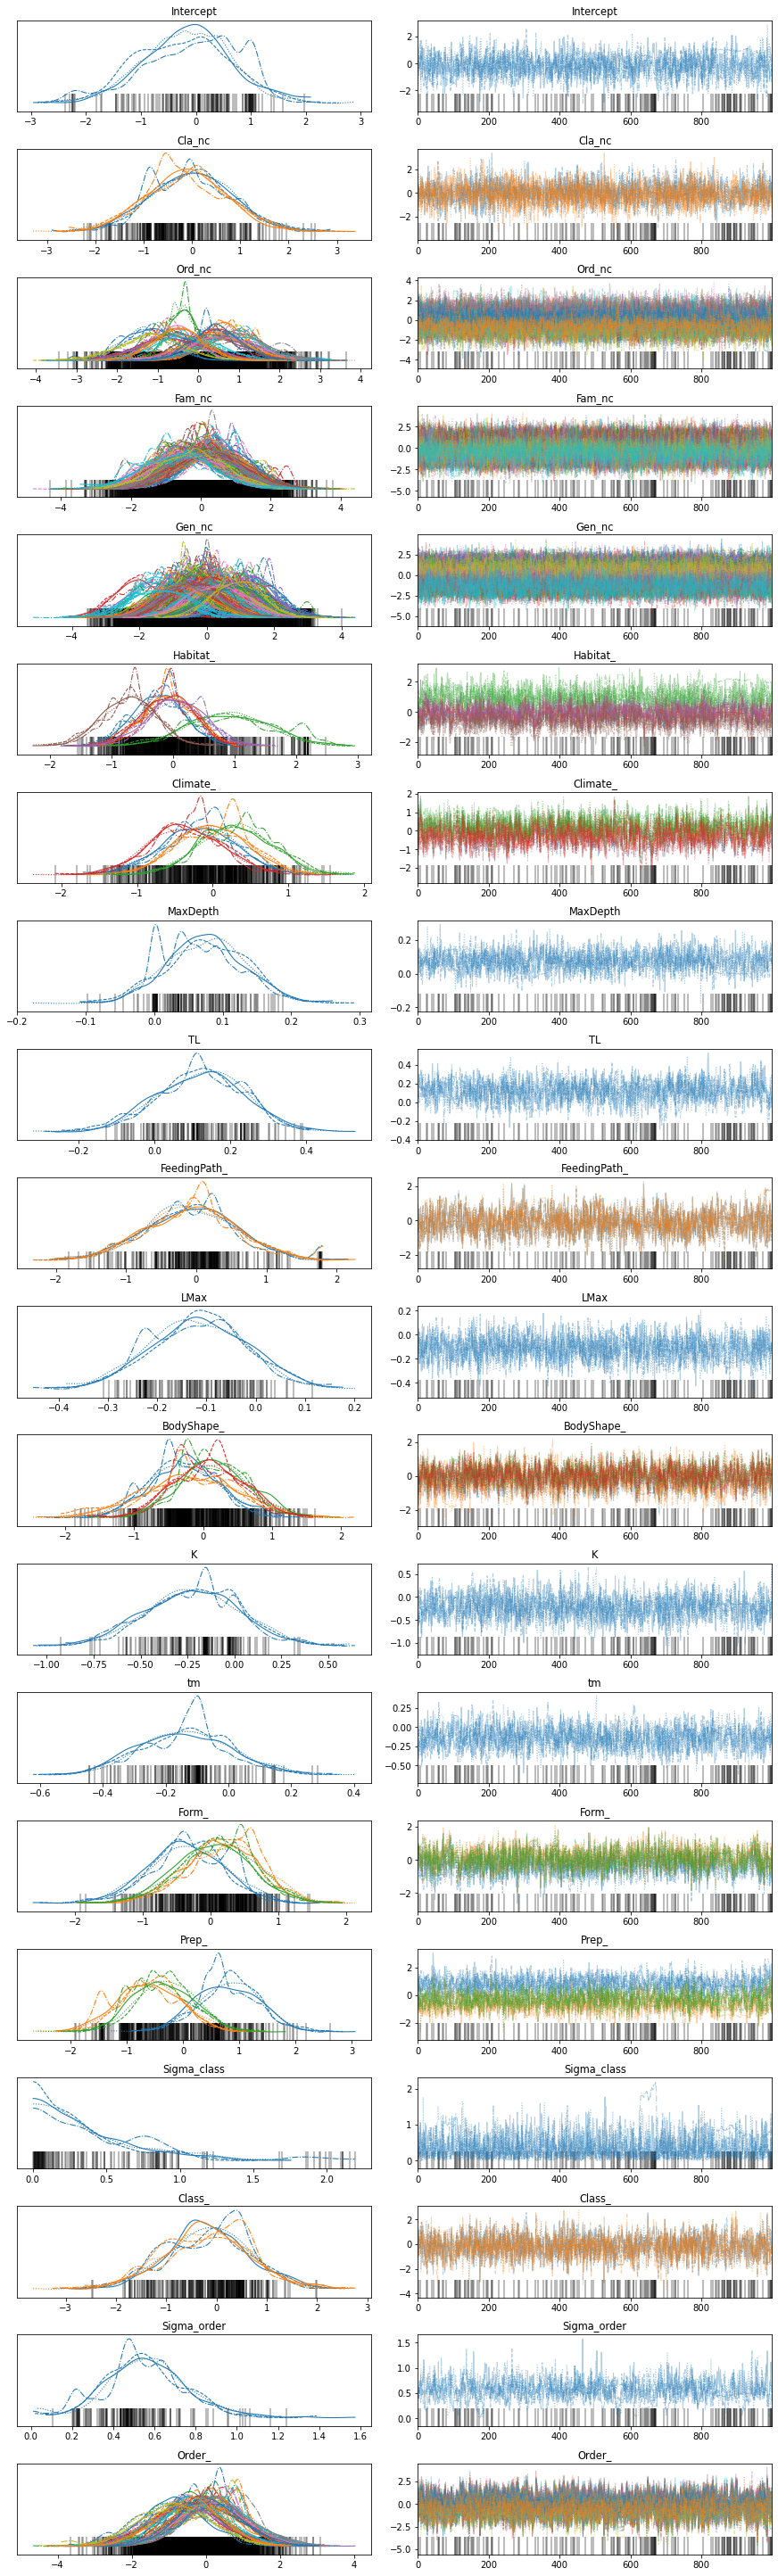

In [24]:
pm.plot_trace(trace).ravel()[0].figure.savefig(nut+'_Trace.jpg')

In [25]:
tmp = pm.summary(trace)

/Users/aaronmacneil/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [26]:
tmp = pm.summary(trace)
colnames = np.array(list(tmp.index), dtype=object)
colnames[match(grep('Habitat',list(colnames)),list(colnames))] = Habitat
colnames[match(grep('Climate',list(colnames)),list(colnames))] = Climate
colnames[match(grep('FeedingPath',list(colnames)),list(colnames))] = FeedingPath
colnames[match(grep('BodyShape',list(colnames)),list(colnames))] = BodyShape
colnames[match(grep('Form',list(colnames)),list(colnames))] = Form
colnames[match(grep('Prep',list(colnames)),list(colnames))] = Prep
colnames[match(grep('Order',list(colnames)),list(colnames))] = Order
colnames[match(grep('Family',list(colnames)),list(colnames))] = Family
colnames[match(grep('Genus',list(colnames)),list(colnames))] = Genus

if len(coords['Class'])>1:
    colnames[match(grep('Class',list(colnames)),list(colnames))] = Class

tmp.index = list(colnames)
tmp.to_csv(nut+'_Summary.csv')

/Users/aaronmacneil/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [27]:
tmp.index

Index(['Intercept', 'Cla_nc[0]', 'Cla_nc[1]', 'Ord_nc[0]', 'Ord_nc[1]',
       'Ord_nc[2]', 'Ord_nc[3]', 'Ord_nc[4]', 'Ord_nc[5]', 'Ord_nc[6]',
       ...
       'ExMu[281]', 'ExMu[282]', 'ExMu[283]', 'ExMu[284]', 'ExMu[285]',
       'ExMu[286]', 'ExMu[287]', 'ExMu[288]', 'ExMu[289]', 'ExMu[290]'],
      dtype='object', length=733)

In [28]:
pm.summary(trace).to_csv(nut+'_Summary.csv',index=False)

/Users/aaronmacneil/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [29]:
pm.summary(trace)

/Users/aaronmacneil/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.149,0.841,-1.851,1.286,0.034,0.024,618.0,618.0,619.0,881.0,1.01
Cla_nc[0],0.001,0.851,-1.579,1.612,0.025,0.018,1144.0,1144.0,1141.0,1970.0,1.00
Cla_nc[1],-0.104,0.865,-1.759,1.498,0.020,0.015,1802.0,1559.0,1798.0,2400.0,1.00
Ord_nc[0],-0.572,0.736,-1.981,0.761,0.027,0.022,759.0,558.0,737.0,551.0,1.02
Ord_nc[1],0.641,0.543,-0.437,1.561,0.021,0.018,672.0,482.0,678.0,940.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
ExMu[286],0.452,0.070,0.329,0.584,0.002,0.001,1601.0,1601.0,1414.0,1627.0,1.00
ExMu[287],0.452,0.070,0.329,0.584,0.002,0.001,1601.0,1601.0,1414.0,1627.0,1.00
ExMu[288],0.452,0.070,0.329,0.584,0.002,0.001,1601.0,1601.0,1414.0,1627.0,1.00
ExMu[289],0.452,0.070,0.329,0.584,0.002,0.001,1601.0,1601.0,1414.0,1627.0,1.00


In [30]:
# Export traces
out = pm.backends.tracetab.trace_to_dataframe(trace)
colnames = np.array(list(out.columns), dtype=object)
colnames[match(grep('Habitat',list(colnames)),list(colnames))] = Habitat
colnames[match(grep('Climate',list(colnames)),list(colnames))] = Climate
colnames[match(grep('FeedingPath',list(colnames)),list(colnames))] = FeedingPath
colnames[match(grep('BodyShape',list(colnames)),list(colnames))] = BodyShape
colnames[match(grep('Form',list(colnames)),list(colnames))] = Form
colnames[match(grep('Prep',list(colnames)),list(colnames))] = Prep
colnames[match(grep('Order',list(colnames)),list(colnames))] = Order
colnames[match(grep('Family',list(colnames)),list(colnames))] = Family
colnames[match(grep('Genus',list(colnames)),list(colnames))] = Genus

if len(coords['Class'])>1:
    colnames[match(grep('Class',list(colnames)),list(colnames))] = Class

out.columns = list(colnames)
out.to_csv(nut+'_results.csv')

In [31]:
Class

['Actinopterygii', 'Elasmobranchii']

In [32]:
out.head()

,Intercept,Cla_nc__0,Cla_nc__1,Ord_nc__0,Ord_nc__1,Ord_nc__2,Ord_nc__3,Ord_nc__4,Ord_nc__5,Ord_nc__6,...,ExMu__281,ExMu__282,ExMu__283,ExMu__284,ExMu__285,ExMu__286,ExMu__287,ExMu__288,ExMu__289,ExMu__290
0,-0.761359,-1.005973,-0.959003,-1.766153,0.878025,-0.635268,1.732235,0.490809,0.538348,-1.679034,...,0.285205,0.541804,0.541804,0.541804,0.541804,0.541804,0.541804,0.541804,0.541804,0.376967
1,0.039160,-0.903621,-1.011596,-0.078263,0.586139,-0.373318,0.734899,-0.292299,0.781569,-1.061923,...,0.105116,0.478136,0.478136,0.478136,0.478136,0.478136,0.478136,0.478136,0.478136,0.340891
2,0.586705,0.415812,0.008560,0.397343,1.305406,-0.767327,-0.458504,1.506660,-1.088591,-1.224105,...,0.341897,0.423818,0.423818,0.423818,0.423818,0.423818,0.423818,0.423818,0.423818,0.687762
3,-0.324359,0.053582,-0.405283,-0.548188,0.132523,-0.560557,2.344342,0.221656,1.647563,-1.706984,...,0.096631,0.551253,0.551253,0.551253,0.551253,0.551253,0.551253,0.551253,0.551253,0.174599
4,-0.220447,-0.134575,-0.853707,-1.121619,0.407210,-0.727666,0.897162,2.269841,1.339814,-1.464692,...,0.152785,0.428021,0.428021,0.428021,0.428021,0.428021,0.428021,0.428021,0.428021,0.289534


# Posterior predictive

In [33]:
posterior_predictive = pm.sample_posterior_predictive(trace, model=Model_1)

In [34]:
idata_checks = az.from_pymc3(
        model=Model_1,
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive)

In [35]:
def plot_ppc_loopit(idata, title):
    fig = plt.figure(figsize=(12,9))
    ax_ppc = fig.add_subplot(211)
    ax1 = fig.add_subplot(223); ax2 = fig.add_subplot(224)
    az.plot_ppc(idata, ax=ax_ppc);
    for ax, ecdf in zip([ax1, ax2], (False, True)):
        az.plot_loo_pit(idata, y="Yi", ecdf=ecdf, ax=ax);
    ax_ppc.set_title(title)
    ax_ppc.set_xlabel("")
    return np.array([ax_ppc, ax1, ax2])

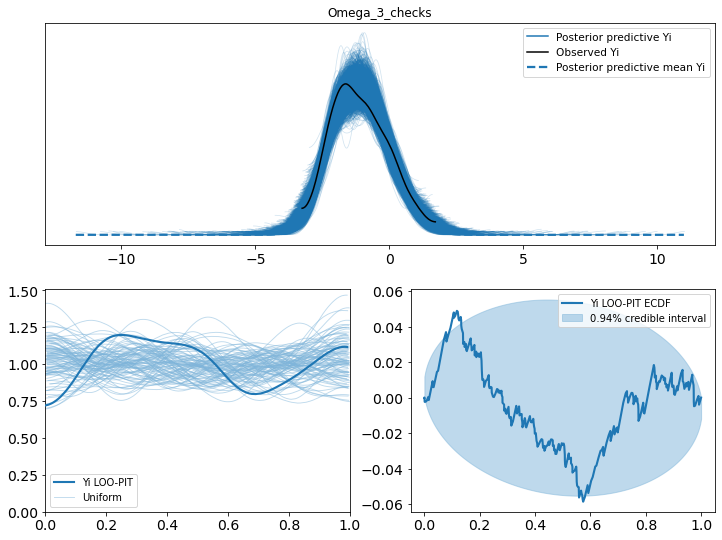

In [36]:
plot_ppc_loopit(idata_checks,nut+'_checks').ravel()[0].figure.savefig(nut+'_LooPit.jpg')

In [37]:
# Grab observation-level predictions
Ypred_mu = np.quantile(trace['ExMu'].T,0.5,axis=1)
Ypred_l90 = np.quantile(trace['ExMu'].T,0.05,axis=1)
Ypred_u90 = np.quantile(trace['ExMu'].T,0.95,axis=1)

# Proportion of observations captured
'Captured '+str(np.round(np.mean(np.array([ylo<y<yup for y,ylo,yup in zip(Y,Ypred_l90,Ypred_u90)]))*100,1))+'% of '+nut+' observations'

'Captured 71.8% of Omega_3 observations'

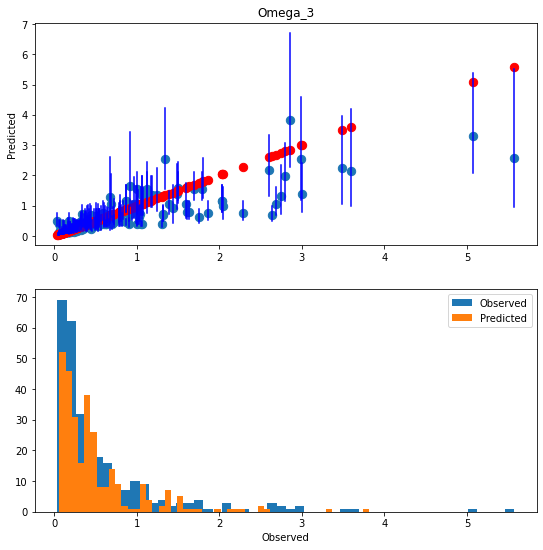

In [46]:
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# 1 to 1
ax1.plot((Y,Y),(Ypred_l90,Ypred_u90),c='b')
ax1.scatter(Y,Ypred_mu,s=70)
ax1.scatter(Y,Y,s=70,c='red')
ax1.set_ylabel('Predicted')
ax1.set_title(nut)

# Histogram
ax2.hist(Y,bins=50,label='Observed')
ax2.hist(Ypred_mu,bins=50, label='Predicted')
ax2.set_xlabel('Observed')
ax2.legend()
plt.savefig(nut+'_ObsPred.jpg');